# Perform the gauge transformation without approximation

Set the relevant parameters and variables

In [2]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2.5         
N = 128 
tau_sim = 1.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS     

# Glasma fields
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.68        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.2 * g**2 * mu         
uv = 10.0       


nevents = 1

In [3]:
import os

os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su

Using Numba
Using SU(3)
Using double precision


/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define the simulation routine

In [18]:
from tqdm import tqdm 

# Simulation routine
def simulate():
    
    # Dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N/L*hbarc
    DT = 1.0/DTS 
    maxt = int(tau_sim/a*DTS)
    
    # We create the object Glasma Simulation
    s = core.Simulation(N, DT, g)
    
    # We intialize the Glasma fields
    va = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create an object to store the fields at every time step
    ux_sim = np.zeros((maxt, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    aeta_sim = np.zeros((maxt, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create objects to store the plus links links
    up_temp = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the gauge transformation operator
    vlc_dag = np.zeros((maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to store the plus links in lc gauge
    up_lc = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create an object to reorder the z coordinate in a suitable way for Meijian's code
    up_reorder = np.zeros((maxt//DTS-1, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We set them to unit
    for xplus in range(maxt//DTS):
        for y in range(N):
            for z in range(N):
                up_temp[xplus, y, z] = su.unit()
    
    # We first simulate the Glasma event and store the fields at every time step
    for t in range(maxt):
        
        # Evolve the Glasma fields
        core.evolve_leapfrog(s)
        
        # Store the fields at every time step
        u1 = s.u1.copy()
        ux_sim[t] = u1[:, 0, :].reshape(N, N, su.GROUP_ELEMENTS)
        
        aeta = s.aeta1.copy()
        aeta_sim[t] = aeta.reshape(N, N, su.GROUP_ELEMENTS)
    
    
    # We now perform the gauge transformation to the lc gauge
    with tqdm(total=maxt//DTS) as pbar:
        for xplus in range(maxt//DTS):
                
            for y in range(N):
                for z in range(N):
                    
                    # We construct the plus link in LC coordinates from the links in Milne coordinates
                    if -xplus<(z-N//2)<xplus:
                        tau = round(DTS*np.sqrt(xplus**2 - (z-N//2)**2))
                        
                        aeta_fact = su.mul_s(aeta_sim[tau, xplus+1, y], -(z-N/2)/tau**2)
                        ut = su.mexp(aeta_fact)
                        
                        up_temp[xplus, y, z] = su.mul(ux_sim[tau, xplus, y], ut)
                        
                    # We construct the gauge transformation operator
                    vlc0 = su.unit(); vlc1 = su.unit()
                    for xminus in range(0, -xplus, -1):
                        if -(xplus+xminus)<(z-N//2)<(xplus+xminus):
                            tau = round(DTS*np.sqrt((xplus+xminus)**2 - (z-N//2)**2))
                            
                            aeta_fact = su.mul_s(aeta_sim[tau, xplus-xminus-1, y], -(z-N/2)/tau**2)
                            ut = su.mexp(aeta_fact)
                            
                            umin_dag = su.mul(su.dagger(ut), ux_sim[tau, xplus-xminus-1, y])
                            
                            vlc1 = su.mul(vlc0, umin_dag)
                            vlc0 = np.copy(vlc1)
                    vlc_dag[xplus, y, z] = vlc1

                    # We perform the gauge transformation of the field at the previous time step
                    if xplus != 0:
                        aux = su.mul(up_temp[(xplus-1), y, z], vlc_dag[xplus, y, z])
                        aux2 = su.mul(su.dagger(vlc_dag[(xplus-1), y, z]), aux)
                        up_lc[(xplus-1), y, z] = su.dagger(aux2)
                    
                    # We reorder the fields in a suitable format to input in Meijian's code
                    if z-N/2 >= 0:
                        up_reorder[xplus-1, y, z-N//2] = up_lc[xplus-1, y, z]
                            
                    else:
                        up_reorder[xplus-1, y, N//2+z] = up_lc[xplus-1, y, z]
                            
            pbar.update(1)
            
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    up_jetsim = up_reorder.reshape(maxt//DTS-1, N*N, su.GROUP_ELEMENTS)
    
    output['up_temp'] = up_temp
    output['up_lc'] = up_lc
    output['up_jetsim'] = up_jetsim
    
    return output

In [19]:
# We perform the simulation
import warnings
warnings.filterwarnings('ignore')

for n in range (nevents):
    
    output = simulate()
    
    up_temp = output['up_temp']
    up_lc = output['up_lc']
    up_jetsim = output['up_jetsim']
    
    # np.save(os.path.join('simulations', 'ux_lc', 'result_%i.npy' %n), up_jetsim)

Kernel xi: 0 d:  0 did not reach goal. check:  0.004766146590147661
Kernel xi: 0 d:  1 did not reach goal. check:  0.0006278982827046442
Kernel xi: 1 d:  0 did not reach goal. check:  0.004897128304468437
Kernel xi: 1 d:  1 did not reach goal. check:  0.0019783217259158807
Kernel xi: 2 d:  0 did not reach goal. check:  0.004592909157747151
Kernel xi: 2 d:  1 did not reach goal. check:  0.002417064888765391
Kernel xi: 3 d:  0 did not reach goal. check:  0.004156449800231447
Kernel xi: 3 d:  1 did not reach goal. check:  0.0032999506984937527
Kernel xi: 4 d:  0 did not reach goal. check:  0.003674441422045548
Kernel xi: 4 d:  1 did not reach goal. check:  0.005167257444143589
Kernel xi: 5 d:  0 did not reach goal. check:  0.0024979697769962972
Kernel xi: 5 d:  1 did not reach goal. check:  0.00586374247043553
Kernel xi: 6 d:  0 did not reach goal. check:  0.0009196977344780863
Kernel xi: 6 d:  1 did not reach goal. check:  0.008496743916554556
Kernel xi: 7 d:  0 did not reach goal. check

100%|██████████| 64/64 [01:16<00:00,  1.19s/it]


In [20]:
# Extract the color components
up_temp_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_temp)
up_lc_comp = np.apply_along_axis(su.get_algebra_factors_from_group_element_approximate, 3, up_lc)

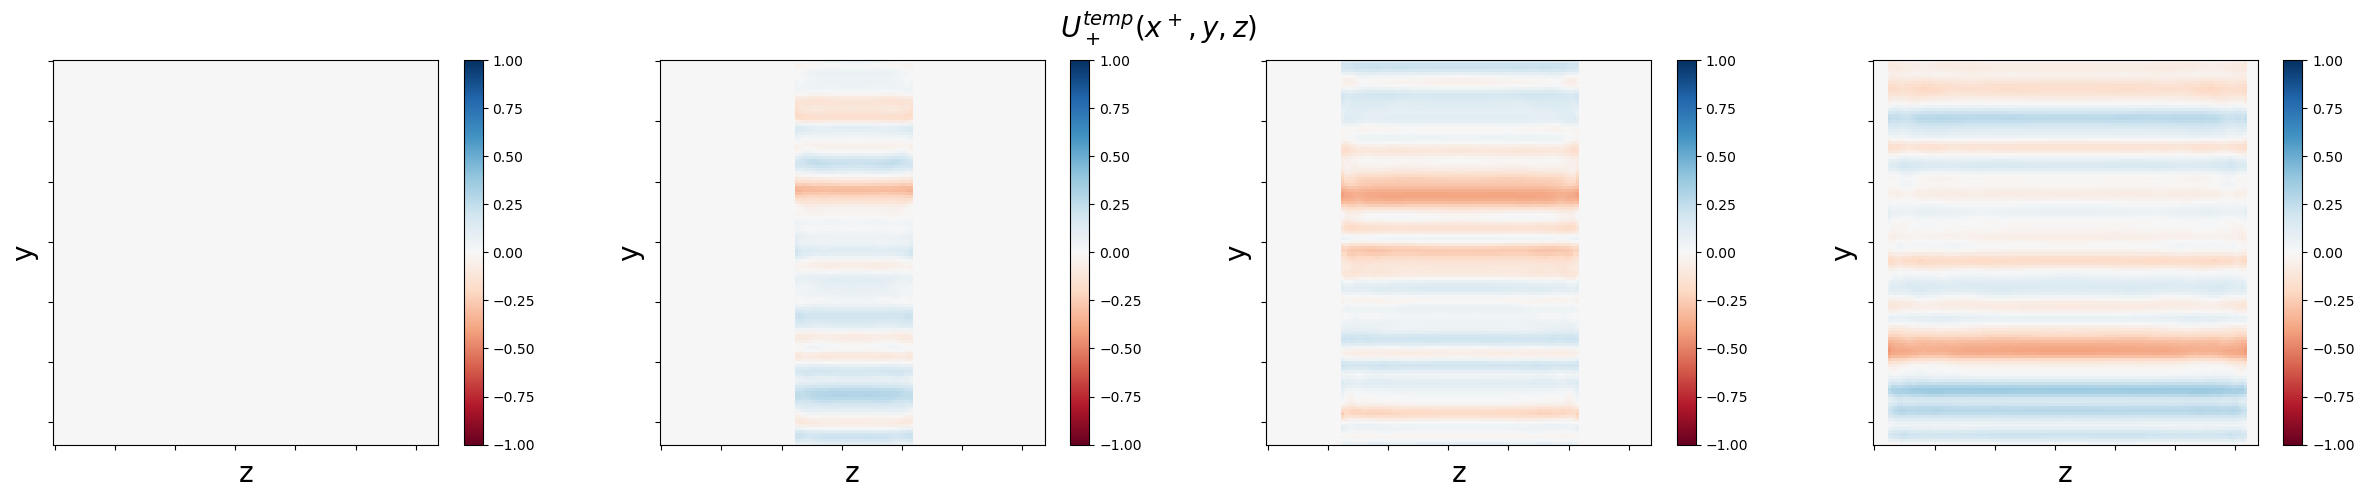

In [21]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$U_+^{temp}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(up_temp_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('temporal_gauge_fields', bbox_inches='tight')

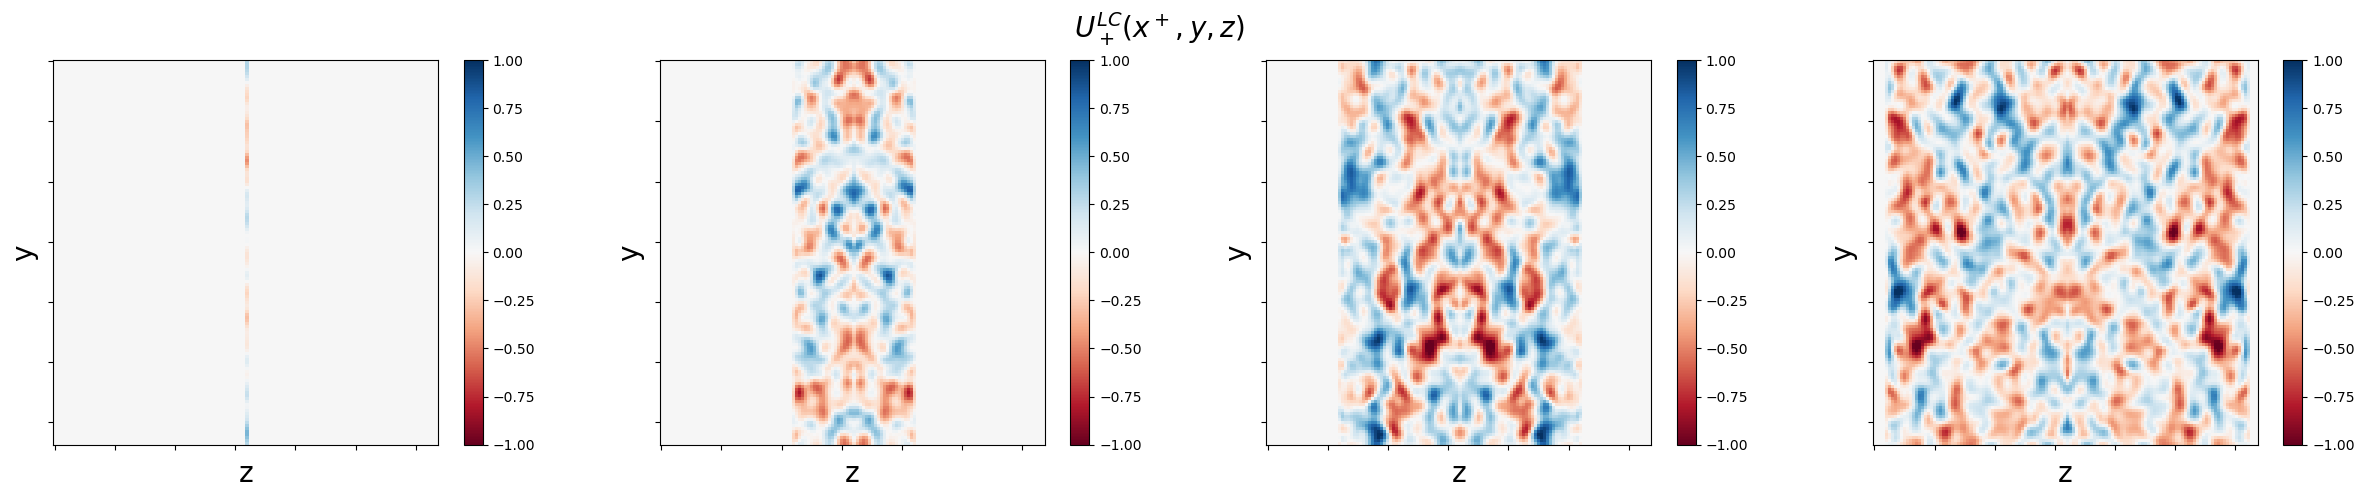

In [22]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$U_+^{LC}(x^+, y, z)$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(up_lc_comp[tau, :, :, 0].real, cmap='RdBu', vmin=-1, vmax=1) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('lc_gauge_fields', bbox_inches='tight')

Let us now check the gauge transformation with the plaquettes

In [35]:
from tqdm import tqdm 

# Simulation routine
def simulate():
    
    # Dictionary to store the results
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N/L*hbarc
    DT = 1.0/DTS 
    maxt = int(tau_sim/a*DTS)
    
    # We create the object Glasma Simulation
    s = core.Simulation(N, DT, g)
    
    # We intialize the Glasma fields
    va = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu/E0, m=ir/E0, uv=uv/E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create an object to store the fields at every time step
    ux_sim = np.zeros((maxt, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create objects to store the plus links links
    up_temp = np.zeros((2, maxt//DTS, N, N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We set them to unit
    for xplus in range(maxt//DTS):
        for y in range(N):
            for z in range(N):
                up_temp[xplus, y, z] = su.unit()
    
    # We first simulate the Glasma event and store the fields at every time step
    for t in range(maxt):
        
        # Evolve the Glasma fields
        core.evolve_leapfrog(s)
        
        # Store the fields at every time step
        u1 = s.u1.copy()
        ux_sim[t] = u1[:, 0, :].reshape(N, N, su.GROUP_ELEMENTS)
    
    
    # We now perform the gauge transformation to the lc gauge at x^+ = 0 and x^+ = 1
    with tqdm(total=maxt//DTS) as pbar:
        for xplus in range(maxt//DTS):
                
            for y in range(N):
                for z in range(N):
                    
                    # We construct the plus link in LC coordinates from the links in Milne coordinates
                    if -xplus<(z-N//2)<xplus:
                        tau = round(DTS*np.sqrt(xplus**2 - (z-N//2)**2))
                        
                        up_temp[0, xplus, y, z] = ux_sim[tau, xplus, y]
                    
                    elif -(xplus+1)<(z-N//2)<xplus+1:
                        tau = round(DTS*np.sqrt((xplus+1)**2 - (z-N//2)**2))
                        
                        up_temp[1, xplus, y, z] = ux_sim[tau, xplus-1, y]
                    
                            
            pbar.update(1)
    
    
    for xplus in range(maxt//DTS-1):
        for y in range(N):
            for z in range(N):
                
                if xplus != 0:
                    aux1 = su.mul(up_temp[0, xplus, y, z], su.dagger(up_temp[0, xplus-1, y, z]))
    
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    
    output['res_temp'] = res_temp

    return output

In [36]:
# We perform the simulation
import warnings
warnings.filterwarnings('ignore')

output = simulate()

res_temp = output['res_temp']
res_lc = output['res_lc']
res = output['res']

Kernel xi: 0 d:  0 did not reach goal. check:  0.0030996760346087542
Kernel xi: 0 d:  1 did not reach goal. check:  0.0023169264357887375
Kernel xi: 1 d:  0 did not reach goal. check:  0.0030826886162158107
Kernel xi: 1 d:  1 did not reach goal. check:  0.00203523636831216
Kernel xi: 2 d:  0 did not reach goal. check:  0.0040340303508865525
Kernel xi: 2 d:  1 did not reach goal. check:  0.0013186314029248985
Kernel xi: 3 d:  0 did not reach goal. check:  0.0056097143246335865
Kernel xi: 3 d:  1 did not reach goal. check:  0.0009119779201082799
Kernel xi: 4 d:  0 did not reach goal. check:  0.006674841596640949
Kernel xi: 4 d:  1 did not reach goal. check:  0.00018389331595611812
Kernel xi: 5 d:  0 did not reach goal. check:  0.006517643208956225
Kernel xi: 5 d:  1 did not reach goal. check:  0.0007630528795861482
Kernel xi: 6 d:  0 did not reach goal. check:  0.006170251105079464
Kernel xi: 6 d:  1 did not reach goal. check:  0.0032606097767432732
Kernel xi: 7 d:  0 did not reach goal.

100%|██████████| 63/63 [02:39<00:00,  2.53s/it]


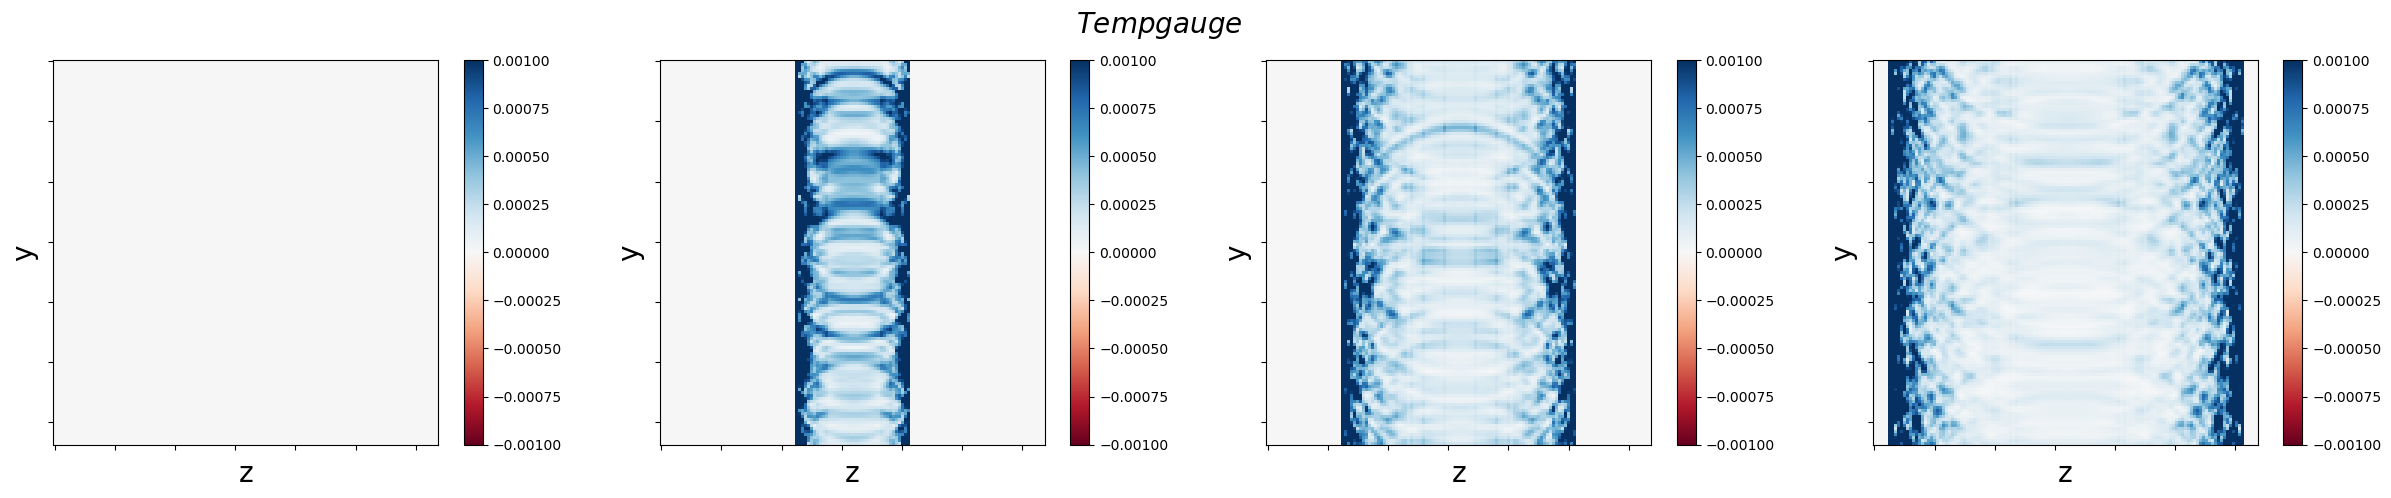

In [37]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$Temp gauge$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(res_temp[tau, :, :].real, cmap='RdBu', vmin=-0.001, vmax=0.001) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('test_before_trans', bbox_inches='tight')

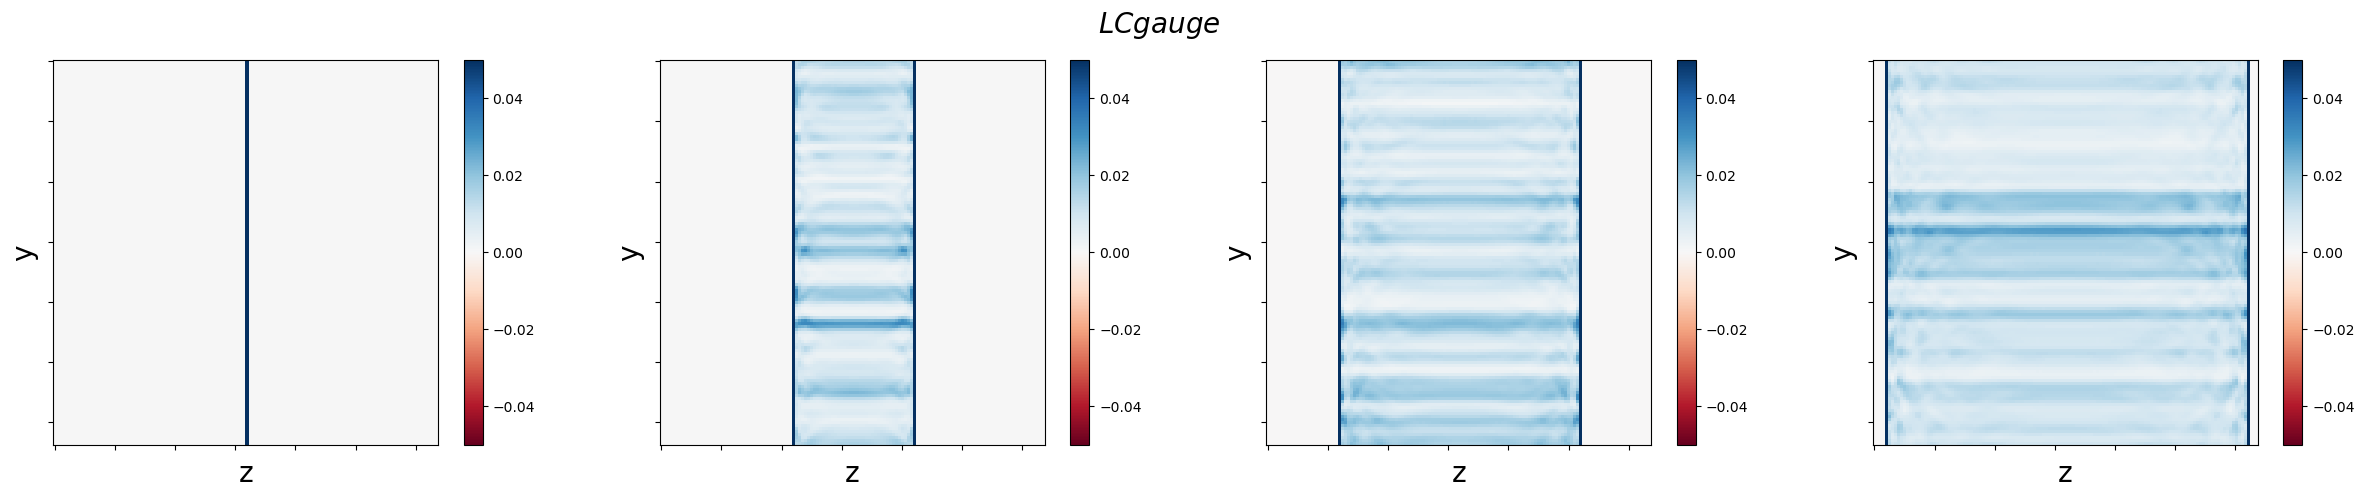

In [40]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$LC gauge$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(res_lc[tau, :, :].real, cmap='RdBu', vmin=-0.05, vmax=0.05) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('test_after_trans', bbox_inches='tight')

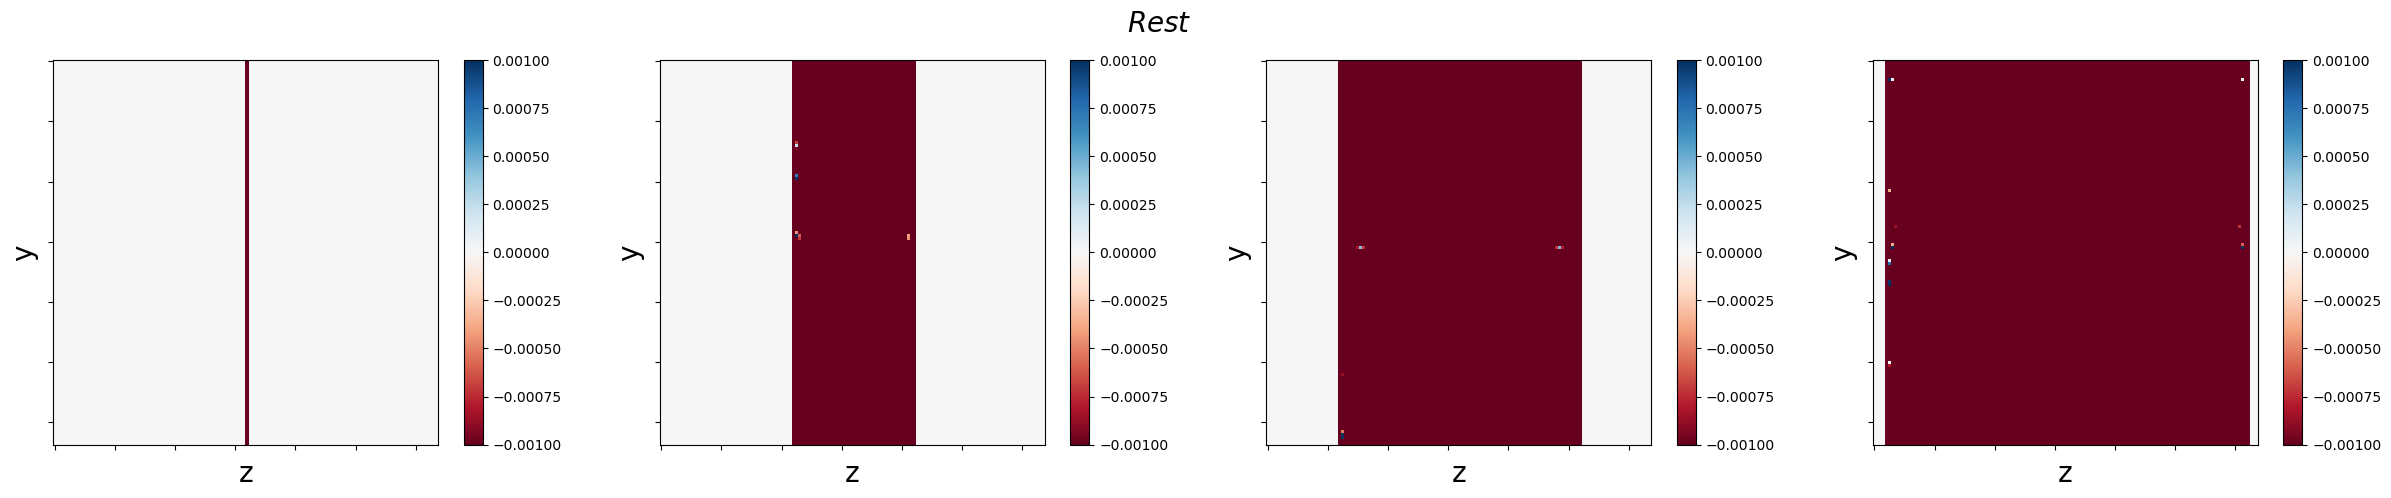

In [32]:
# We plot the reordered temporal gauge results
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, nplus//20 +1, figsize=(30,5))
fig.suptitle(r'$Rest$', fontsize=20)

for t in range(nplus//20 + 1): 
    tau = 20*t
    
    plot1 = axs[t].imshow(res[tau, :, :].real, cmap='RdBu', vmin=-0.001, vmax=0.001) 
    cbar = plt.colorbar(plot1, ax = axs[t])
    
    axs[t].set_xticklabels([]); axs[t].set_yticklabels([])
    axs[t].set_ylabel('y', fontsize=20); axs[t].set_xlabel('z', fontsize=20)
    
# plt.savefig('test_rest', bbox_inches='tight')